# Deep Learning for Movie Recommendation
In this notebook, I'll build a deep learning model movie recommendations system on the MovieLens 1M dataset.

This will be my 3rd attempt doing this. 
* In the [1st attempt](https://github.com/khanhnamle1994/movielens/blob/master/Content_Based_and_Collaborative_Filtering_Models.ipynb), I tried out content-based and memory-based collaboratice filtering, which rely on the calculation of users and movies' similarity scores. As no training or optimization is involved, these are easy to use approaches. But their performance decrease when we have sparse data which hinders scalability of these approaches for most of the real-world problems.
* In the [2nd attempt](https://github.com/khanhnamle1994/movielens/blob/master/SVD_Model.ipynb), I tried out a matrix factorization model-based collaborative filtering approach called Singular Vector Decomposition, which reduces the dimension of the dataset and gives low-rank approximation of user tastes and preferences.

In this post, I will use a Deep Learning / Neural Network approach that is up and coming with recent development in machine learning and AI technologies.

![movixai](images/movixai.png)

## Loading Datasets
Similar to what I did for the previous notebooks, I loaded the 3 datasets into 3 dataframes: *ratings*, *users*, and *movies*. Additionally, to make it easy to use series from the *ratings* dataframe as training inputs and output to the Keras model, I set *max_userid* as the max value of user_id in the ratings and *max_movieid* as the max value of movie_id in the ratings.

In [13]:
# Import libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()

# Reading ratings file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading ratings file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])

## Matrix Factorization for Collaborative Filtering
I have discussed this extensively in my 2nd notebook, but want to revisit it here as the baseline approach. The idea behind matrix factorization models is that attitudes or preferences of a user can be determined by a small number of hidden factors. We can call these factors as **Embeddings**.

Intuitively, we can understand embeddings as low dimensional hidden factors for movies and users. For e.g. say we have 3 dimensional embeddings for both movies and users.

For instance, for movie A, the 3 numbers in the movie embedding matrix represent 3 different characteristics about the movie, such as:
* How recent is the movie A?
* How much special effects are in movie A?
* How CGI-driven is movie A? 

For user B, the 3 numbers in the user embedding matrix represent:
* How much does user B like Drama movie?
* How likely does user B to give a 5-star rating?
* How often does user B watch movies?

![matrix-factorization](images/matrix-factorization.png)

I definitely would want to create a training and validation set and optimize the number of embeddings by minimizing the RMSE. Intuitively, the RMSE will decrease on the training set as the number of embeddings increases (because I'm approximating the original ratings matrix with a higher rank matrix). Here I create a training set by shuffling randomly the values from the original ratings dataset.

In [14]:
RNG_SEED = 42
# Create training set
shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [5411 5439  367 ...  853 4032  785] , shape = (1000209,)
Movies: [2682  903 3716 ... 3101 3478 1390] , shape = (1000209,)
Ratings: [2 5 4 ... 3 5 4] , shape = (1000209,)


## Deep Learning Model
The idea of using deep learning is similar to that of Model-Based Matrix Factorization. In matrix factorizaion, we decompose our original sparse matrix into product of 2 low rank orthogonal matrices. For deep learning implementation, we don’t need them to be orthogonal, we want our model to learn the values of embedding matrix itself. The user latent features and movie latent features are looked up from the embedding matrices for specific movie-user combination. These are the input values for further linear and non-linear layers. We can pass this input to multiple relu, linear or sigmoid layers and learn the corresponding weights by any optimization algorithm (Adam, SGD, etc.).

### Build the Model
I created a sparse matrix factoring algorithm in Keras for my model in [CFModel.py](https://github.com/khanhnamle1994/movielens/blob/master/CFModel.py). Here are the main components:

* A left embedding layer that creates a Users by Latent Factors matrix.
* A right embedding layer that creates a Movies by Latent Factors matrix.
* When the input to these layers are (i) a user id and (ii) a movie id, they'll return the latent factor vectors for the user and the movie, respectively.
* A merge layer that takes the dot product of these two latent vectors to return the predicted rating.

This code is based on the approach outlined in [Alkahest](http://www.fenris.org/)'s blog post [Collaborative Filtering in Keras](http://www.fenris.org/2016/03/07/index-html).

![embedding-layers](images/embedding-layers.png)

In [15]:
# Import Keras libraries
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# Import CF Model Architecture
from CFModel import CFModel

In [16]:
# Define constants
K_FACTORS = 100 # The number of dimensional embeddings for movies and users
TEST_USER = 2000 # A random test user (user_id = 2000)

I then compile the model using Mean Squared Error (MSE) as the loss function and the AdaMax learning algorithm.

In [17]:
# Define model
model = CFModel(max_userid, max_movieid, K_FACTORS)
# Compile the model using MSE as the loss function and the AdaMax learning algorithm
model.compile(loss='mse', optimizer='adamax')

### Train the Model
Now I need to train the model. This step will be the most-time consuming one. In my particular case, for our dataset with nearly 1 million ratings, almost 6,000 users and 4,000 movies, I trained the model in roughly 6 minutes per epoch (30 epochs ~ 3 hours) inside my Macbook Laptop CPU. I spitted the training and validataion data with ratio of 90/10.

Epoch 1/30
INFO:tensorflow:Assets written to: best_model/assets
28131/28131 - 31s - loss: 13.7772 - val_loss: 12.3825 - 31s/epoch - 1ms/step
Epoch 2/30
INFO:tensorflow:Assets written to: best_model/assets
28131/28131 - 30s - loss: 8.1688 - val_loss: 5.1216 - 30s/epoch - 1ms/step
Epoch 3/30
INFO:tensorflow:Assets written to: best_model/assets
28131/28131 - 29s - loss: 3.8104 - val_loss: 2.9247 - 29s/epoch - 1ms/step
Epoch 4/30
INFO:tensorflow:Assets written to: best_model/assets
28131/28131 - 29s - loss: 2.4119 - val_loss: 2.0596 - 29s/epoch - 1ms/step
Epoch 5/30
INFO:tensorflow:Assets written to: best_model/assets
28131/28131 - 29s - loss: 1.8004 - val_loss: 1.6310 - 29s/epoch - 1ms/step
Epoch 6/30
INFO:tensorflow:Assets written to: best_model/assets
28131/28131 - 29s - loss: 1.4765 - val_loss: 1.3874 - 29s/epoch - 1ms/step
Epoch 7/30
INFO:tensorflow:Assets written to: best_model/assets
28131/28131 - 29s - loss: 1.2836 - val_loss: 1.2350 - 29s/epoch - 1ms/step
Epoch 8/30
INFO:tensorflo

/root/miniconda3/envs/xiamf_182/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/xiamf_182/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/xiamf_182/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/xiamf_182/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/xiamf_182/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: User

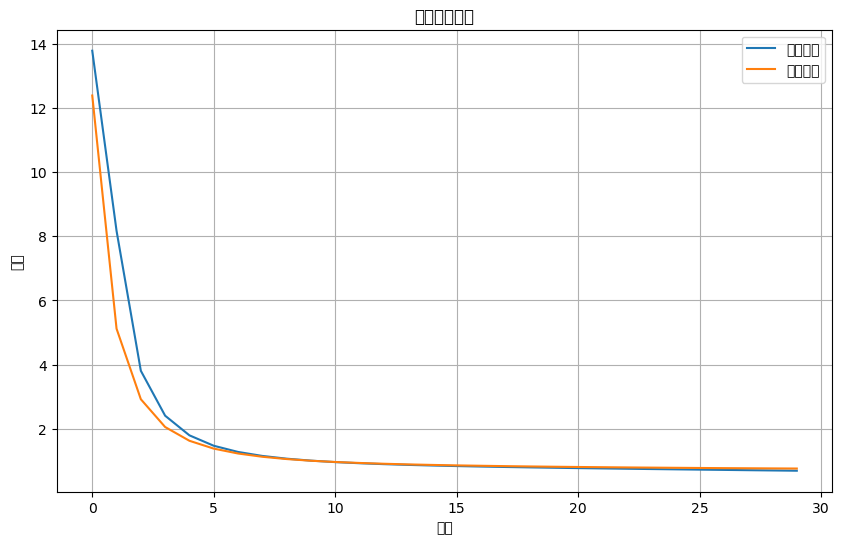

INFO:tensorflow:Assets written to: final_model/assets


In [18]:
# 设置回调函数，使用 TF 格式保存
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint(
        'best_model',  # 移除 .h5 扩展名
        save_best_only=True,
        save_format='tf'  # 使用 TensorFlow SavedModel 格式
    )
]

# 训练模型：30轮，90%训练数据，10%验证数据
history = model.fit(
    [Users, Movies],
    Ratings,
    epochs=30,
    validation_split=0.1,
    verbose=2,
    callbacks=callbacks
)

# 绘制训练历史
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('模型训练历史')
plt.xlabel('轮数')
plt.ylabel('损失')
plt.legend()
plt.grid(True)
plt.show()

# 保存最终模型（如果需要）
model.save('final_model', save_format='tf')

### Root Mean Square Error
During the training process above, I saved the model weights each time the validation loss has improved. Thus, I can use that value to calculate the best validation Root Mean Square Error.

In [26]:
# Show the best validation RMSE
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 30 = 0.8756


The best validation loss is *0.7424* at epoch 17. Taking the square root of that number, I got the RMSE value of *0.8616*, which is better than the RMSE from the SVD Model (*0.8736*).

### Predict the Ratings
The next step is to actually predict the ratings a random user will give to a random movie. Below I apply the freshly trained deep learning model for all the users and all the movies, using 100 dimensional embeddings for each of them. I also load pre-trained weights from *[weights.h5](https://github.com/khanhnamle1994/movielens/blob/master/weights.h5)* for the model.

In [27]:
# Use the pre-trained model
# trained_model = CFModel(max_userid + 1, max_movieid + 1, K_FACTORS)
# trained_model = model
trained_model = CFModel(max_userid, max_movieid, K_FACTORS)
# Load weights
dummy_user = np.array([[0]])
dummy_movie = np.array([[0]])
_ = trained_model([dummy_user, dummy_movie])  

trained_model.load_weights('weights.h5')

As mentioned above, my random test user is has ID 2000.

In [28]:
# Pick a random test user
users[users['user_id'] == TEST_USER]

,user_id,gender,zipcode,age_desc,occ_desc
1999,2000,M,44685,18-24,college/grad student


Here I define the function to predict user's rating of unrated items, using the *rate* function inside the CFModel class in *[CFModel.py](https://github.com/khanhnamle1994/movielens/blob/master/CFModel.py)*.

In [29]:
# Function to predict the ratings given User ID and Movie ID
def predict_rating(user_id, movie_id):
    return trained_model.rate(user_id - 1, movie_id - 1)

Here I show the top 20 movies that user 2000 has already rated, including the *predictions* column showing the values that used 2000 would have rated based on the newly defined *predict_rating* function.

In [30]:
user_ratings = ratings[ratings['user_id'] == TEST_USER][['user_id', 'movie_id', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)

1/1 [==============================] - 0s 18ms/step


,user_id,movie_id,rating,prediction,title,genres
0,2000,1748,5,[3.77919],Dark City (1998),Film-Noir|Sci-Fi|Thriller
1,2000,1907,5,[4.02749],Mulan (1998),Animation|Children's
2,2000,595,5,[4.334908],Beauty and the Beast (1991),Animation|Children's|Musical
3,2000,1619,5,[3.6881766],Seven Years in Tibet (1997),Drama|War
4,2000,2501,5,[4.206387],October Sky (1999),Drama
5,2000,1136,5,[4.495121],Monty Python and the Holy Grail (1974),Comedy
6,2000,1193,5,[4.71845],One Flew Over the Cuckoo's Nest (1975),Drama
7,2000,2321,5,[4.0104923],Pleasantville (1998),Comedy
8,2000,1923,5,[3.2640648],There's Something About Mary (1998),Comedy
9,2000,318,5,[4.743263],"Shawshank Redemption, The (1994)",Drama


No surpise that these top movies all have 5-start rating. Some of the prediction values seem off (those with value 3.7, 3.8, 3.9 etc.).

### Recommend Movies
Here I make a recommendation list of unrated 20 movies sorted by prediction value for user 2000. Let's see it.

In [31]:
recommendations = ratings[ratings['movie_id'].isin(user_ratings['movie_id']) == False][['movie_id']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

1/1 [==============================] - 0s 18ms/step


,movie_id,prediction,title,genres
0,953,[4.8689237],It's a Wonderful Life (1946),Drama
1,668,[4.8668585],Pather Panchali (1955),Drama
2,1423,[4.859523],Hearts and Minds (1996),Drama
3,3307,[4.834415],City Lights (1931),Comedy|Drama|Romance
4,649,[4.8026757],Cold Fever (Ã kÃ¶ldum klaka) (1994),Comedy|Drama
5,669,[4.7974515],Aparajito (1956),Drama
6,326,[4.7848287],To Live (Huozhe) (1994),Drama
7,3092,[4.7611485],Chushingura (1962),Drama
8,3022,[4.7530026],"General, The (1927)",Comedy
9,2351,[4.720693],Nights of Cabiria (Le Notti di Cabiria) (1957),Drama


## Conclusion
In this notebook, I showed how to use a simple deep learning approach to build a recommendation engine for the MovieLens 1M dataset. This model performed better than all the approaches I attempted before (content-based, user-item similarity collaborative filtering, SVD). I can certainly improve this model's performance by making it deeper with more linear and non-linear layers. I leave that task to you then!